## Before starting: select "dtw" kernel

- In the menu bar on top of this notebook, select Kernel > Change Kernel > "dtw"

- In the top right corner, there should be the Python logo and "dtw" should be written next to the circle monitoring kernel activity.


# (Step2) align two sequences with sm-dtw

*In step1*, you previously produced a pair of phyllotaxis sequences: one reference sequence and a test sequence which derives from the first after typical "measurement errors". Each phyllotaxis sequence is made of two sub-sequences: the divergence angles and the internode lengths between successive organs along a stem.

Here, you will use our program `sm-dtw` to realign the test sequence with the reference and detect automatically the potential additions or losses of organs along the test sequence.


## Upload simulated sequences generated in step1

In [31]:
import numpy as np
import pandas as pd

from dtw import DTW
from dtw.tasks.search_free_ends import brute_force_free_ends_search
from dtw.metrics import mixed_dist

In [32]:
ref_df = pd.read_csv("/myapp/docker_sandbox/reference_sequences.csv")
test_df = pd.read_csv("/myapp/docker_sandbox/test_sequences.csv")

In [33]:
# have a look at the table
# check out the PlantID: there should be only one after step1 notebook, default is "MyPlant"
ref_df
# test_df

,PlantID,angles,Internodes
0,MyPlant,123,55
1,MyPlant,114,33
2,MyPlant,139,19
3,MyPlant,160,18
4,MyPlant,146,7
5,MyPlant,122,11
6,MyPlant,121,12
7,MyPlant,117,6
8,MyPlant,151,5
9,MyPlant,146,12


In [34]:
# Create ground-truth & predicted angles and inter-nodes arrays
# Change the PlantID if needed
plant_id = "MyPlant"
seq_ref = np.array([ref_df[ref_df["PlantID"] == plant_id]["angles"],
                            ref_df[ref_df["PlantID"] == plant_id]["Internodes"]]).T
seq_test = np.array([test_df[test_df["PlantID"] == plant_id]["angles"],
                             test_df[test_df["PlantID"] == plant_id]["Internodes"]]).T

## Initialize the DTW object
To performs this alignment, we use the **"merge-split" constraint** to account for organ under or over segmentation.
We also use a **"mixed distance"** reflecting that among the two component of the phyllotaxis, the divergence angles are circular values whereas internode lengths are scalar values

In [35]:
# Variables associated to 'mixed-distance':
    # during realignment, the parameter 'ldist' selects a function to compute the local distance used to compare values of both sequences.
    # ldist can take three possible values: `euclidean_dist()` (default),  `angular_dist()` or `mixed_dist()`
mtype = [True, False] # (mixed_type):  a boolean vector, of size ``n_dim``, indicating whether the k^th component should be treated as an angle (``True``) or a regular scalar value (``False``)
max_ref = np.max(seq_ref[:, 1])
max_test = np.max(seq_test[:, 1])
mspread = [1, max(max_ref, max_test)] # (mixed_spread): a vector of positive scalars, of size ``n_dim``, used to normalize the distance values computed for each component with their typical spread
mweight = [0.5, 0.5] # (mixed weight): weigths attributed to angles and internodes, respectively (positive weights. they do not necessarily sum to 1, but normalized if not)

# naming
seq_names=["Angles", "Internodes"]

## Run a first realignment for phyllotaxis sequences
This first realignment assumes that the start and the end of the paired sequences matches ("**bounded ends**"): in other terms, segmentation errors are excluded from the first and last organs.

In [36]:
dtwcomputer = DTW(seq_test, seq_ref, 
                  constraint='merge_split',ldist=mixed_dist,
                  mixed_type=mtype, mixed_spread=mspread, mixed_weight=mweight,
                  names=seq_names)

************************************ INFOS *************************************
Test sequence length: 17
ference sequence length: 19
Type of constraints: symmetric
Beam size:  None
Free endings: (0, 1)
*********************************** RESULTS ************************************
Alignment:
test seq:  [158  26]  - s[168   5] [144   9]  - s[114  10] [107  20] [118   6] [133   5] [164  13] [147   0]  - s[14  4] [141   5] [133   0] [106   2] [17  3] [95  5] [132   9]  - s[149   6] 
ref seq :  [123  55] [114  33] [139  19] [160  18] [146   7] [122  11] [121  12] [117   6] [151   5] [146  12] [151   3] [149   1] [122   3] [125   8]  -  [99  1]  -  [123   8] [145   6] [143   7] [159   7] 
Optimal path length: 21
Optimal normalized cost: 0.12138461656741228 at cell (16, 18) (non normalized: 2.549076947915658
Array of global distances (x downward, y rightward):
 [[0.397 0.592   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
    inf   inf   inf   inf   inf   inf   inf]
 [1.064 0.8

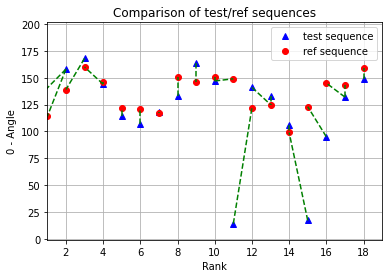

-----> minh, maxh= 0 3
score array= [37. 18. 11. 26.]
 shift =  2


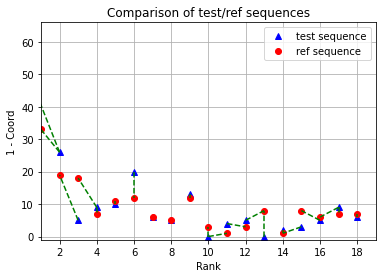

,test,reference,type,cost
0,0,0,s,0.397382
1,0,1,d,0.194874
2,1,2,s,0.213014
3,2,3,s,0.131678
4,2,4,d,0.026887
5,3,5,s,0.033955
6,4,6,s,0.116633
7,5,7,s,0.003928
8,6,8,s,0.070711
9,7,9,s,0.071870


In [37]:
# Print the results with a graphic visusalisation of the alignment
dtwcomputer.run()
dtwcomputer.print_results(graphic_seq_alignment=True)

#Interpret the graphic:
# dotted green lines are matching corresponding intervals:
# one-to-one match (one triangle to one dot): no segmentation issue, possible shifts
# several triangles to one one point: merge events (over-segmentation, some organs were added in the test sequence within a previous ref interval)
# several points to one triangle: split event (under-segmentation, some organs were missed in the test sequence)

## Testing different free-ends
Let's realign the sequence by allowing another value for free-ends. Note that this will not impose that ending intervals are trimmed, but the program will explore this possibility.

The solution may be different, but in that case, the associated normalized cost will also evolves.

In the program, free-ends are specified with a tuple of 2 integers ``(k,l)`` that specifies relaxation bounds on the alignment of sequences endpoints: relaxed by ``k`` at the sequence beginning and relaxed by ``l`` at the sequence ending.


************************************ INFOS *************************************
Test sequence length: 17
ference sequence length: 19
Type of constraints: symmetric
Beam size:  None
Free endings: (3, 4)
*********************************** RESULTS ************************************
Alignment:
test seq:   -   -   -  [158  26] [168   5] [144   9] [114  10] [107  20] [118   6] [133   5] [164  13] [147   0]  - s[14  4] [141   5] [133   0] [106   2] [17  3] [95  5] [132   9] [149   6]  - s
ref seq :  [123  55] [114  33] [139  19] [160  18] [146   7]  -  [122  11] [121  12] [117   6] [151   5] [146  12] [151   3] [149   1] [122   3] [125   8]  -  [99  1]  -  [123   8]  -  [145   6] [143   7] 
Optimal path length: 19
Optimal normalized cost: 0.09105349656493504 at cell (16, 17) (non normalized: 1.7300164347337657
Array of global distances (x downward, y rightward):
 [[0.397 0.195 0.117 0.103 0.352   inf   inf   inf   inf   inf   inf   inf
    inf   inf   inf   inf   inf   inf   inf]
 [0.667 

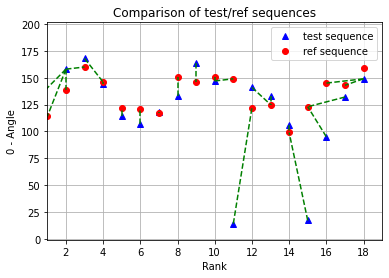

-----> minh, maxh= 0 3
score array= [36. 21. 12. 21.]
 shift =  2


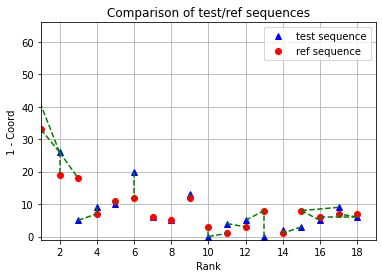

,test,reference,type,cost
0,0,3,s,0.103152
1,1,4,s,0.090168
2,2,4,i,0.026887
3,3,5,s,0.033955
4,4,6,s,0.116633
5,5,7,s,0.003928
6,6,8,s,0.070711
7,7,9,s,0.071870
8,8,10,s,0.041648
9,8,11,d,0.015067


In [38]:
# check the previous values of free-ends: default is (0,1) for perfectly matching start and end sequences.
dtwcomputer.free_ends #check the current value
dtwcomputer.free_ends = (3, 4) #impose a new value
dtwcomputer.run()
dtwcomputer.print_results(graphic_seq_alignment=True)

## Automatic selection of free-ends
Now, we will see how to automatically select an optimal size for free-ends: `sm-dtw` will look for possible organ addition/loss at both ends and compute the normalized cost for each of them. It then select the best free-ends solution based on the evolution of the normalised cost: this one reaches a plateau after this point. The main parameter to select here is `free_ends_eps`: it determines the minimum difference to previous minimum normalized cost to consider tested free-ends as the new best combination (ie *"the lower, the easier to increase free-ends"*)

Note however that trimming of sequences is limited to max 40% of the shortest sequence length among the pair to avoid overfitting of extremely short and costless alignment solutions.

In [41]:
free_ends, n_cost = brute_force_free_ends_search(dtwcomputer, free_ends_eps=0.001)
print(f"Found free-ends {free_ends} with a normalized distance of {n_cost}.")

Found free-ends (3, 5) with a normalized distance of 0.08643731828301422.
